In [1]:
import numpy as np
import pandas as pd

import scipy.stats

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 20})

model_colors = {'Species-aware':"#E69F00",'Species-agnostic':"#56B4E9",
                'Species-aware-tempscale':"#E69F00",'Species-agnostic-tempscale':"#56B4E9",
                'DNABERT':"#CC79A7", '11-mer':"#F0E442",'13-mer':"#F0E442",'PhyloP-100way':"#0072B2",'PhyloP-241way':"#D55E00",'NT-MS-v2-500M':"#009E73"}

In [2]:
#10th and 90th percentiles 

percentiles_pref = {"Species-agnostic":[0.166,0.556],"Species-aware":[0.167,0.554],"DNABERT":[0.16,0.692],"NT-MS-v2-500M":[0.0547,0.829],"13-mer":[0.113,0.632],"PhyloP-100way":[-0.885,2.02],"PhyloP-241way":[-0.915,3.01]}
percentiles_palt_inv = {"Species-agnostic":[0.928,3.12],"Species-aware":[0.983,3.02],"DNABERT":[0.916,3.51],"NT-MS-v2-500M":[0.638,3.94],"13-mer":[0.807,3.63],}
percentiles_ratio = {"Species-agnostic":[-0.655,2.27],"Species-aware":[-0.579,2.13],"DNABERT":[-0.692,2.79],"NT-MS-v2-500M":[-1.59,3.17],"13-mer":[-1.04,3.01]}

In [3]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/MLM/'

In [30]:
utr_variants = pd.read_csv(data_dir + 'perbase_pred/model_scores_snp.tsv', sep='\t')

utr_variants.groupby('split').label.value_counts()

split    label
clinvar  0.0      10000
         1.0        215
eQTL     0.0      10000
         1.0       2196
gnomAD   1.0      10000
         0.0      10000
Name: count, dtype: int64

In [31]:
split = 'eQTL' # clinvar, gnomAD or eQTL
scoring = 'pref' #pref, paltinv, ratio

In [32]:
utr_variants = utr_variants[utr_variants.split==split]

In [33]:
def get_contig_table(model):

    if scoring=='pref':
        score = utr_variants[f'{model}_ref']
        perc_low, perc_high = percentiles_pref[model]
    elif scoring=='ratio':
        score = np.log(utr_variants[f'{model}_ref']/utr_variants[f'{model}_alt'])
        perc_low, perc_high = percentiles_ratio[model]
    elif scoring=='paltinv':
        score = np.log(1/utr_variants[f'{model}_alt'])
        perc_low, perc_high = percentiles_palt_inv[model]         
            
    pathogenic_bottom = ((score<perc_low)&(utr_variants.label==1)).sum()
    pathogenic_top = ((score>perc_high)&(utr_variants.label==1)).sum()
    
    benign_bottom = ((score<perc_low)&(utr_variants.label==0)).sum()
    benign_top = ((score>perc_high)&(utr_variants.label==0)).sum()

    contig_table = [[pathogenic_top,benign_top], [pathogenic_bottom,benign_bottom] ]

    return contig_table, score

In [34]:
models = ('DNABERT','NT-MS-v2-500M','13-mer','Species-agnostic','Species-aware','PhyloP-100way','PhyloP-241way')

In [35]:
odds_ratios = []
score = {}

for model in models:
    
    contig_table, score[model] = get_contig_table(model)
    fisher_test = scipy.stats.fisher_exact(contig_table)
        
    print(model,contig_table, fisher_test)

    OR = fisher_test.statistic
    CI_95_high = np.exp(np.log(OR)+1.96*np.sqrt((1/np.array(contig_table)).sum()))
    CI_95_low = np.exp(np.log(OR)-1.96*np.sqrt((1/np.array(contig_table)).sum()))

    odds_ratios.append((model, fisher_test.statistic,CI_95_low, CI_95_high,fisher_test.pvalue))

odds_ratios = pd.DataFrame(odds_ratios,columns=['model','OR', 'CI_95_low','CI_95_high', 'pvalue'])#.sort_values(by='OR', ascending=False)
odds_ratios['padj'] = odds_ratios.pvalue*len(models)
odds_ratios.set_index('model', inplace=True)

DNABERT [[39, 844], [550, 2708]] SignificanceResult(statistic=0.22751400258509263, pvalue=2.3331734204643646e-25)
NT-MS-v2-500M [[14, 165], [59, 343]] SignificanceResult(statistic=0.49327170005136106, pvalue=0.021282986399972094)
13-mer [[81, 672], [477, 2189]] SignificanceResult(statistic=0.5531502695417789, pvalue=1.446672243614709e-06)
Species-agnostic [[45, 873], [541, 2665]] SignificanceResult(statistic=0.25392076528764984, pvalue=1.0848172997450168e-23)
Species-aware [[46, 878], [557, 2672]] SignificanceResult(statistic=0.25133014072295856, pvalue=1.4010439398072476e-24)
PhyloP-100way [[60, 322], [482, 2434]] SignificanceResult(statistic=0.9409551300224221, pvalue=0.7141376464630145)
PhyloP-241way [[118, 412], [279, 1497]] SignificanceResult(statistic=1.53674705084038, pvalue=0.0006350513727636108)


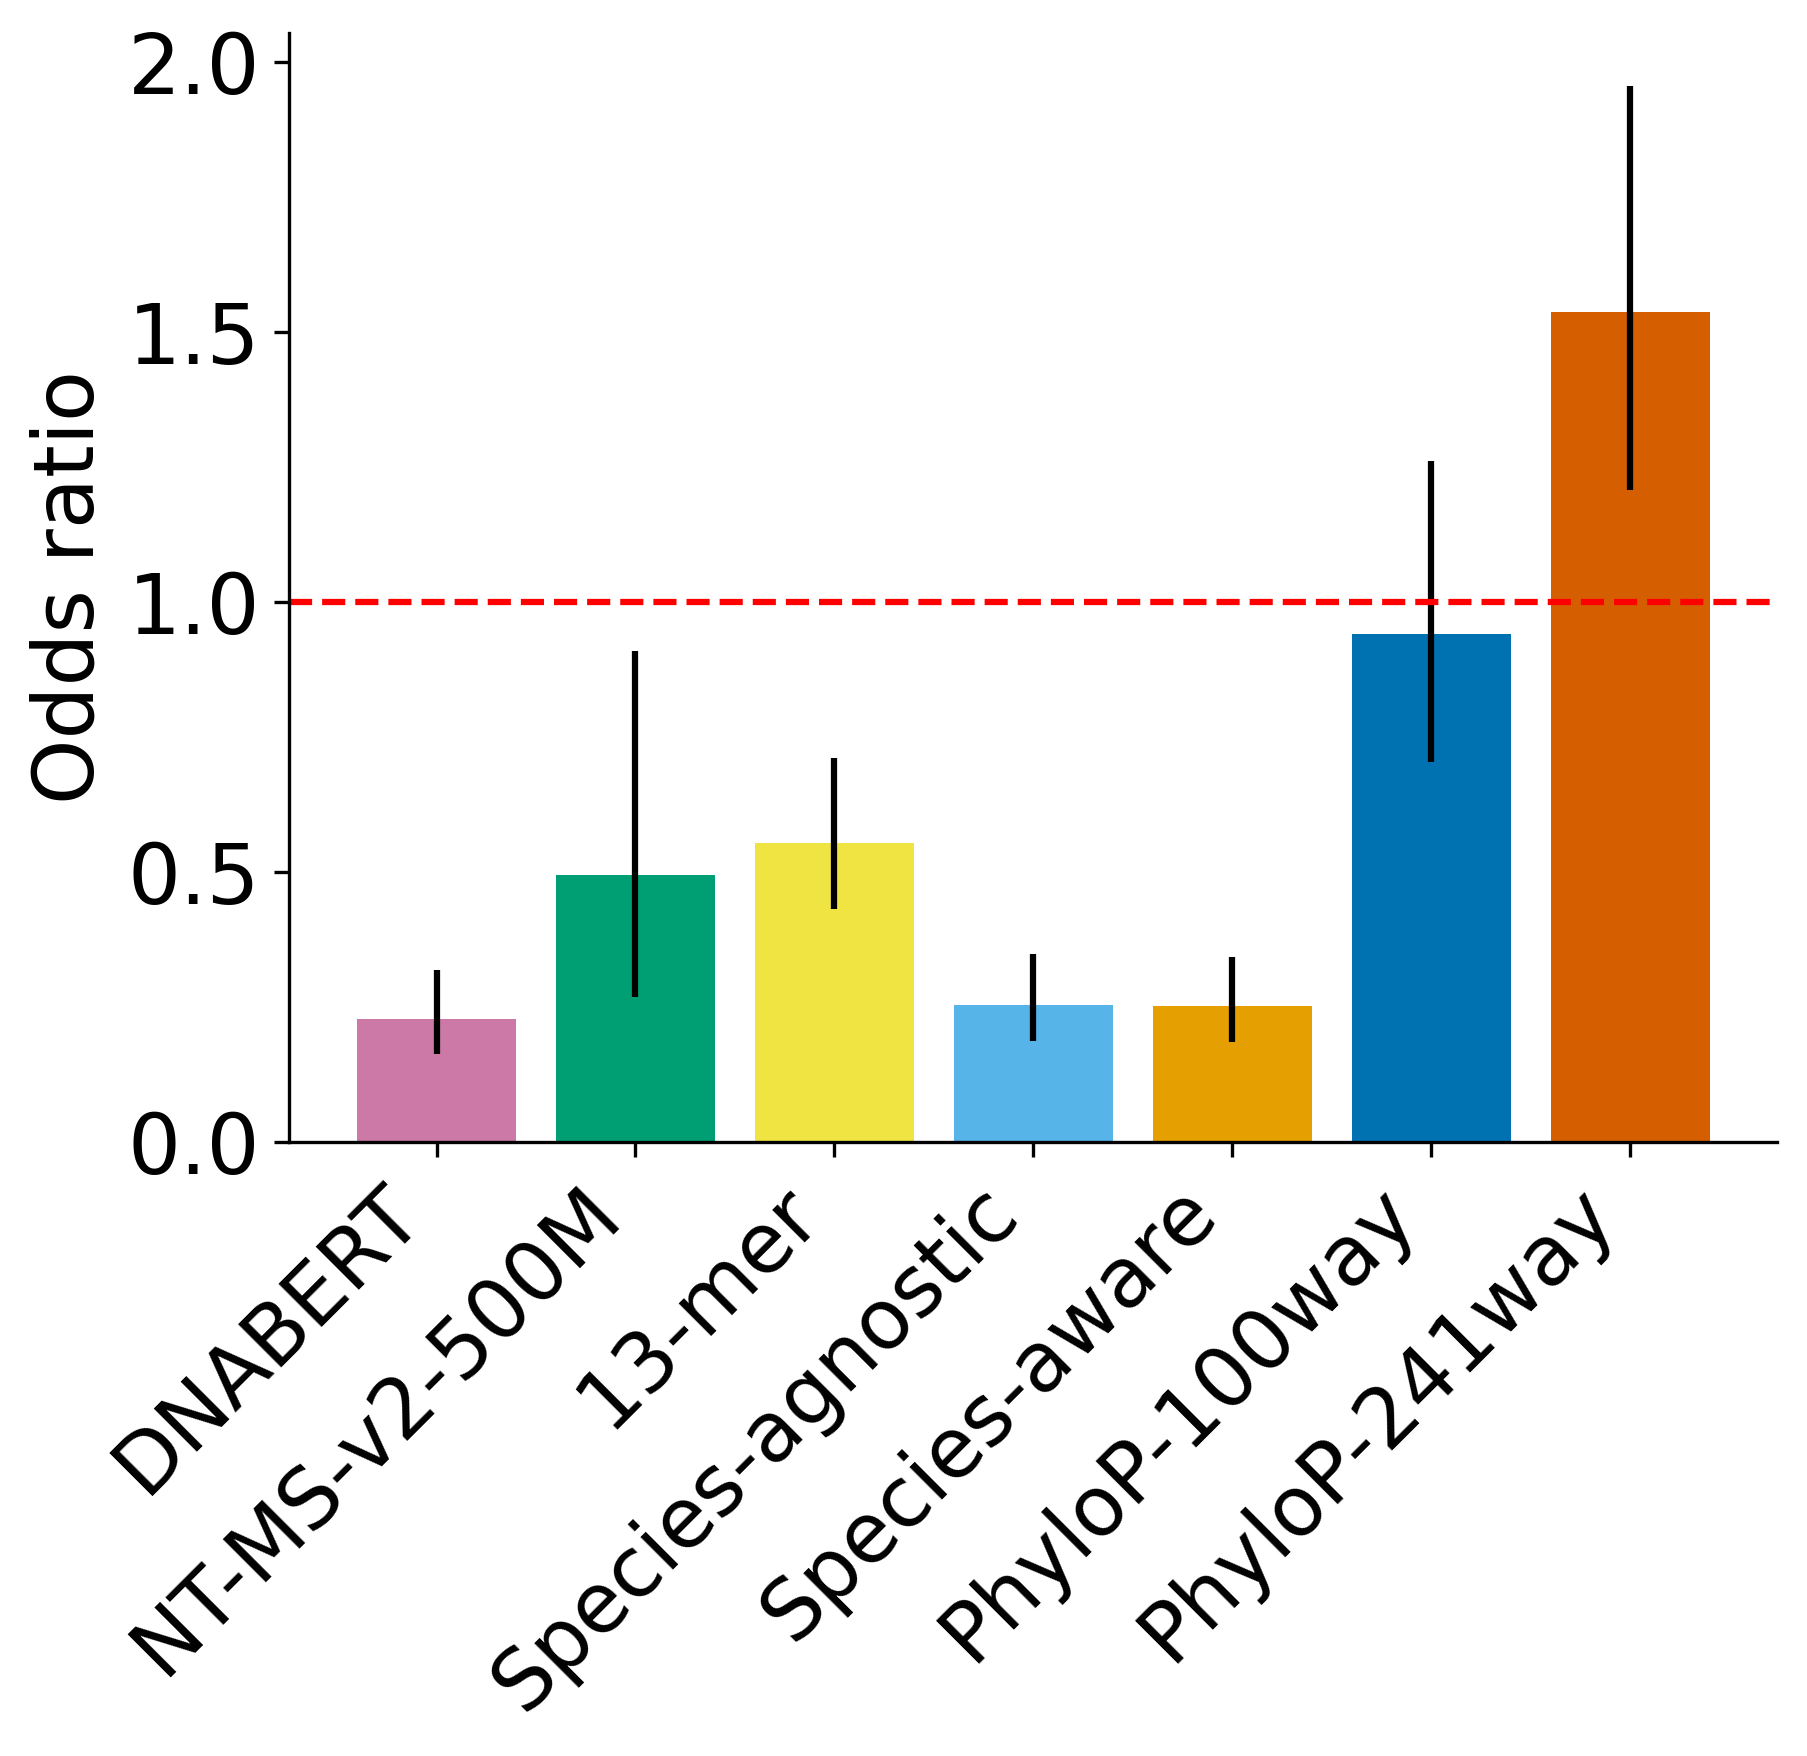

In [36]:
fig, ax = plt.subplots(dpi=300)

ax.bar(odds_ratios.index, odds_ratios.OR, yerr=[odds_ratios.OR-odds_ratios.CI_95_low,odds_ratios.CI_95_high-odds_ratios.OR], color=odds_ratios.index.map(model_colors))
plt.xticks(rotation=45, ha="right")
ax.set_ylabel('Odds ratio')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if odds_ratios.OR.max()>50:
    ax.set_yscale('log')

ax.axhline(1,0,len(models),color='r', linestyle='--')

for model_idx, model in enumerate(odds_ratios.index):
    padj = odds_ratios.loc[model,'padj']
    if padj<1e-4:
        stars='****'
    elif padj<1e-3:
        stars='***'
    elif padj<1e-2:
        stars = '**'
    elif padj<5e-2:
        stars = '*'
    else:
        stars = 'ns'
    #ax.text(model_idx, odds_ratios.loc[model].OR+odds_ratios.OR.max()*0.03, f'{stars}',ha='center', va='center')
    #ax.text(model_idx, odds_ratios.loc[model].OR*1.3, f'{stars}',ha='center', va='center')
#ax.set_ylim([0,260])